In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np

In [2]:
R = 1.0
F0 = 1.0

In [8]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)


def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    print(x.shape)
    print(df(nn,x).shape, (R * x * (1 - x)))
    interior_loss = df(nn, x) - R * x * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss


def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


Streaming output truncated to the last 5000 lines.
        [0.2469],
        [0.2222],
        [0.1728],
        [0.0988],
        [0.0000]], grad_fn=<MulBackward0>)
Epoch: 0 - Loss: 1.037420
torch.Size([10, 1])
torch.Size([10, 1]) tensor([[0.0000],
        [0.0988],
        [0.1728],
        [0.2222],
        [0.2469],
        [0.2469],
        [0.2222],
        [0.1728],
        [0.0988],
        [0.0000]], grad_fn=<MulBackward0>)
torch.Size([10, 1])
torch.Size([10, 1]) tensor([[0.0000],
        [0.0988],
        [0.1728],
        [0.2222],
        [0.2469],
        [0.2469],
        [0.2222],
        [0.1728],
        [0.0988],
        [0.0000]], grad_fn=<MulBackward0>)
torch.Size([10, 1])
torch.Size([10, 1]) tensor([[0.0000],
        [0.0988],
        [0.1728],
        [0.2222],
        [0.2469],
        [0.2469],
        [0.2222],
        [0.1728],
        [0.0988],
        [0.0000]], grad_fn=<MulBackward0>)
torch.Size([10, 1])
torch.Size([10, 1]) tensor([[0.0000],
        [0.0988

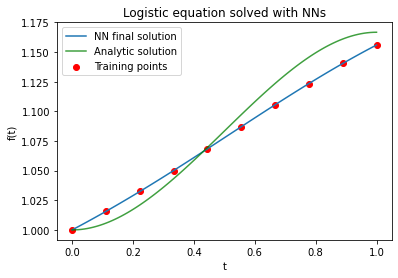

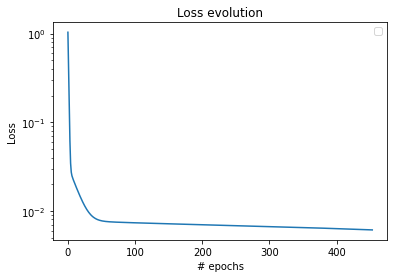

In [9]:
domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
x = x.reshape(x.shape[0], 1)

nn_approximator = NNApproximator(4, 10)
assert check_gradient(nn_approximator, x)

# f_initial = f(nn_approximator, x)
# ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
)

x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
)

# plotting
fig, ax = plt.subplots()

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
ax.plot(
    x_eval.detach().numpy(),
    numeric_solution.y.T,
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()

In [4]:
from functools import partial

Epoch: 0 - Loss: 1.317189
Epoch: 1000 - Loss: 0.000844
Epoch: 2000 - Loss: 0.000214
Epoch: 3000 - Loss: 0.000186
Epoch: 4000 - Loss: 0.000165
Epoch: 5000 - Loss: 0.000147
Epoch: 6000 - Loss: 0.000133
Epoch: 7000 - Loss: 0.000121
Epoch: 8000 - Loss: 0.000111
Epoch: 9000 - Loss: 0.000102
Epoch: 10000 - Loss: 0.000094
Epoch: 11000 - Loss: 0.000087
Epoch: 12000 - Loss: 0.000081
Epoch: 13000 - Loss: 0.000076
Epoch: 14000 - Loss: 0.000071
Epoch: 15000 - Loss: 0.000067
Epoch: 16000 - Loss: 0.000063
Epoch: 17000 - Loss: 0.000059
Epoch: 18000 - Loss: 0.000056
Epoch: 19000 - Loss: 0.000053


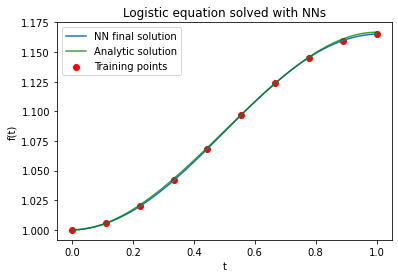

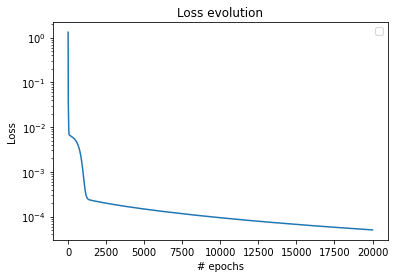

In [5]:
domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
x = x.reshape(x.shape[0], 1)

nn_approximator = NNApproximator(4, 10)
assert check_gradient(nn_approximator, x)

# f_initial = f(nn_approximator, x)
# ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
)

x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
)

# plotting
fig, ax = plt.subplots()

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
ax.plot(
    x_eval.detach().numpy(),
    numeric_solution.y.T,
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()